# 1.1 Exploratory Analysis: Evans 2001 Replication

## Summary
Explores a subset of the dataset through a replication of Leonard Evans' 2001 paper on female vs. male fatality risk. 

## Changes
- 1/20/2020 v1.0 Mitchell Abrams
- 3/26/2020 v2.0 Mitchell Abrams: update to new loaders, simplify report

In [ ]:
# These are the parameters for runs with Papermill
run_id = 'run0'
start_year = 1975
end_year = 2018
first_run = False
target_folder = 'full'
load_from = 'full'
use_dask = False

image_outputs = 'default'

subsets = [
    {'data': "SEAT_POS_C == 'Front Seat – Right Side' and "
                     "RESTRAINTS_C == 'Not Used' and RESTRAINTS_S == 'Not Used'",
     'subject': {'sex': 'SEX_S', 'age': 'AGE_S',
                 'dead': 'DEAD_S', 'id': 'PER_ID_S',
                 'bin': [15] + [x for x in range(22, 101, 5)]
                },
     'control': {'sex': 'SEX_C', 'age': 'AGE_C',
                 'dead': 'DEAD_C', 'id': 'PER_ID_C',
                 'bin': [15, 24, 34, 54, 100]
                },
     'title': 'Unbelted drivers'
    }, #Unbelted drivers
    {'data': "SEAT_POS_C == 'Front Seat – Right Side' and "
             "RESTRAINTS_C == 'Not Used' and RESTRAINTS_S == 'Not Used'",
     'subject': {'sex': 'SEX_C', 'age': 'AGE_C',
                 'dead': 'DEAD_C', 'id': 'PER_ID_C',
                 'bin': [x for x in range(0, 101, 5)]
                },
     'control': {'sex': 'SEX_S', 'age': 'AGE_S',
                 'dead': 'DEAD_S', 'id': 'PER_ID_S',
                 'bin': [15, 24, 34, 54, 100]
                },
     'title': 'Unbelted right front passengers'
    }, #Unbelted front right passengers
    {'data': "SEAT_POS_C == 'Front Seat – Right Side' and "
             "RESTRAINTS_C == 'Used' and RESTRAINTS_S == 'Used'",
     'subject': {'sex': 'SEX_S', 'age': 'AGE_S',
                 'dead': 'DEAD_S', 'id': 'PER_ID_S',
                 'bin': [15] + [x for x in range(22, 101, 5)]
                },
     'control': {'sex': 'SEX_C', 'age': 'AGE_C',
                 'dead': 'DEAD_C', 'id': 'PER_ID_C',
                 'bin': [15, 24, 34, 54, 100]
                },
     'title': 'Belted drivers'
    }, #Belted drivers
    {'data': "SEAT_POS_C == 'Front Seat – Right Side' and "
             "RESTRAINTS_C == 'Used' and RESTRAINTS_S == 'Used'",
     'subject': {'sex': 'SEX_C', 'age': 'AGE_C',
                 'dead': 'DEAD_C', 'id': 'PER_ID_C',
                 'bin': [x for x in range(0, 101, 5)]
                },
     'control': {'sex': 'SEX_S', 'age': 'AGE_S',
                 'dead': 'DEAD_S', 'id': 'PER_ID_S',
                 'bin': [15, 24, 34, 54, 100]
                },
     'title': 'Belted right front passengers'
    }, #Belted front right passengers
    {'data': "SEAT_POS_C == 'Second Seat – Left Side' and "
             "RESTRAINTS_C == 'Not Used' and RESTRAINTS_S == 'Not Used'",
     'subject': {'sex': 'SEX_C', 'age': 'AGE_C',
                 'dead': 'DEAD_C', 'id': 'PER_ID_C',
                 'bin': [x for x in range(0, 101, 5)]
                },
     'control': {'sex': 'SEX_S', 'age': 'AGE_S',
                 'dead': 'DEAD_S', 'id': 'PER_ID_S',
                 'bin': [15, 24, 34, 54, 100]
                },
     'title': 'Unbelted left rear passengers'
    }, #Unbelted rear left passengers
    {'data': "SEAT_POS_C == 'Second Seat – Right Side' and "
             "RESTRAINTS_C == 'Not Used' and RESTRAINTS_S == 'Not Used'",
     'subject': {'sex': 'SEX_C', 'age': 'AGE_C',
                 'dead': 'DEAD_C', 'id': 'PER_ID_C',
                 'bin': [x for x in range(0, 101, 5)]
                },
     'control': {'sex': 'SEX_S', 'age': 'AGE_S',
                 'dead': 'DEAD_S', 'id': 'PER_ID_S',
                 'bin': [15, 24, 34, 54, 100]
                },
     'title': 'Unbelted right rear passengers'
    }, #Unbelted rear right passengers
]

In [1]:
import os
import sys
from pathlib import Path
module_path = os.path.abspath(os.path.join('../..'))
if module_path not in sys.path:
    sys.path.append(module_path)
    
fig_out = Path(module_path) / "reports" / "figures" / image_outputs
fig_out.mkdir(parents=True, exist_ok=True)

In [2]:
%reload_ext autoreload
%autoreload 2

import pandas as pd
import matplotlib.pyplot as plt
plt.style.use(['ircobi'])

from matplotlib.ticker import MultipleLocator

%matplotlib inline

import logging
logger = logging.getLogger("distributed.utils_perf")
logger.setLevel(logging.ERROR)

from src.data.data_loader_pooch import *
from src.data.fars_utils import createPerID, getWeightedAvg, standard_error

from tqdm.notebook import tqdm

pd.set_option('precision', 3)
pd.set_option('display.max_columns', 999)


## Load data

In [75]:
vehicles, accidents, people = load_pipeline(start_year, end_year, 
                                            first_run=first_run, target_folder=target_folder,
                                            load_from=load_from, use_dask=use_dask)

Loading mappings...
Mappings loaded.
Loading data...
Data loaded.
Processing People.
Processing Accidents.
Done


## Reduce column set, merge for analysis
For this analysis, only require information on people.

- Split people into drivers and passengers
- Merge passengers to drivers (one record per driver-passenger pair)
- Merge with vehicles table, only require vehicle type information

In [94]:
# Keep only a subset of the columns, save computation space
# and shorten runtime
veh_col_keep = ['ST_CASE', 'VEH_NO', 'BODY_TYP', 'MOD_YEAR', 'YEAR',
               'PASSENGER_CAR', 'MOTORCYCLE', 'LIGHT_TRUCK_OR_VAN', 'LARGE_TRUCK']
vehicles.drop(columns=vehicles.columns.difference(veh_col_keep), inplace=True)

per_col_keep = ['PERSON_TYPE', 'ST_CASE', 'YEAR', 'PER_NO', 'AGE', 'SEX', 
                'VEH_NO', 'RESTRAINTS', 'SEAT_POS', 'INJ_SEV', 
                'AIR_BAG_DEPLOYMENT', 'DEAD', 'PER_ID', 'HELMETED']
people.drop(columns=people.columns.difference(per_col_keep), inplace=True)

accidents = accidents[['ST_CASE', 'STATE', 'YEAR']]

AttributeError: 'NoneType' object has no attribute 'drop'

In [7]:
# Create a merged data table, by crash, with drivers merged with each passenger.
subjects = people[people['PERSON_TYPE'] == 'Driver']
controls = people[people['PERSON_TYPE'] == 'Passenger']

data = subjects.merge(controls, how = 'inner', on=['VEH_NO', 'ST_CASE', 'YEAR'], suffixes=['_S', '_C']).merge(
                     vehicles, how = 'inner', on=['VEH_NO', 'ST_CASE', 'YEAR'])

## Run double pair comparison
1. Create age bins for analysis
2. Run double-pair on bins
3. Merge

## Full Replication

In [33]:
vehicle_results = {}
for veh_type in ['PASSENGER_CAR', 'LIGHT_TRUCK_OR_VAN']:
    filtered = data.loc[(data[veh_type]) &
                        (data['AIR_BAG_DEPLOYMENT_C'] != 'Deployed') &
                        (data['AIR_BAG_DEPLOYMENT_S'] != 'Deployed') &
                        (data['SEX_C'].isin(['Male', 'Female'])) & 
                        (data['SEX_S'].isin(['Male', 'Female'])) &
                        (data['AGE_C'] < 99) & (data['AGE_S'] < 99)].reset_index().drop(columns=['index'])
    results = []
    titles = []
    counts = []
    all_res = []
    for test in tqdm(subsets):
        subset = filtered.query(test['data']).reset_index().drop(columns=['index'])
        subject = test['subject']
        control = test['control']

        control_bins = pd.cut(x=subset[control['age']], bins=control['bin'])
        subject_bins = pd.cut(x=subset[subject['age']], bins=subject['bin'])

        subset['AGE_C_Bin'] = control_bins
        subset['AGE_S_Bin'] = subject_bins

        grouped = subset.groupby(['AGE_C_Bin', 'AGE_S_Bin', control['sex']])

        soln = []

        for name, group in grouped:
            #print(name)
            a = group.loc[(group[subject['sex']] == 'Female') 
                          & (group[subject['dead']])]
            b = group.loc[(group[subject['sex']] == 'Female') 
                          & (group[control['dead']])]
            c = group.loc[(group[subject['sex']] == 'Male') 
                          & (group[subject['dead']])]
            d = group.loc[(group[subject['sex']] == 'Male') 
                          & (group[control['dead']])]

            A = a[subject['id']].nunique()
            B = b[control['id']].nunique()
            C = c[subject['id']].nunique()
            D = d[control['id']].nunique()
            if (A > 0) and (B>0) and (C > 0) and (D > 0):
                r1 = A/B
                r2 = C/D
                R = r1/r2
                serr = standard_error(R, A, B, C, D)
                soln.append([name[0], name[1], name[2], A, B, C, D, r1, r2, R, serr])

        #print(soln)
        result = pd.DataFrame(soln, columns = ['Control Age', 'Subject Age', 'Control Sex', 'A', 'B', 'C', 'D', 'r1', 'r2', 'R', 'DeltaR'])
        weighted_result = result.groupby(['Subject Age']).apply(getWeightedAvg).reset_index()

        weighted_result['Age'] = weighted_result['Subject Age'].apply(lambda x: x.mid + .5)
        this_count = result['A'].sum() + result['C'].sum()
        results.append(weighted_result.copy())
        all_res.append(result.copy())
        titles.append(test['title'])
        counts.append(this_count)
    vehicle_results[veh_type] = {'results': results,
                                 'titles': titles,
                                 'counts': counts,
                                 'all_res': all_res}

In [ ]:
filtered = data.loc[(data['MOTORCYCLE']) &
                    (data['AIR_BAG_DEPLOYMENT_C'] != 'Deployed') &
                    (data['AIR_BAG_DEPLOYMENT_S'] != 'Deployed') &
                    (data['SEX_C'].isin(['Male', 'Female'])) & 
                    (data['SEX_S'].isin(['Male', 'Female'])) &
                    (data['AGE_C'] < 99) & (data['AGE_S'] < 99)].reset_index().drop(columns=['index'])
results = []
titles = []
counts = []
all_res = []
subsets = [{'data': "HELMETED_C == 'Helmeted' and HELMETED_S == 'Helmeted'",
         'subject': {'sex': 'SEX_C', 'age': 'AGE_C',
                     'dead': 'DEAD_C', 'id': 'PER_ID_C',
                     'bin': [x for x in range(0, 101, 5)]
                    },
         'control': {'sex': 'SEX_S', 'age': 'AGE_S',
                     'dead': 'DEAD_S', 'id': 'PER_ID_S',
                     'bin': [15, 24, 34, 54, 100]
                    },
         'title': 'Helmeted Motorcycle Passenger'
        },
          {'data': "HELMETED_C == 'Not Helmeted' and HELMETED_S == 'Not Helmeted'",
         'subject': {'sex': 'SEX_C', 'age': 'AGE_C',
                     'dead': 'DEAD_C', 'id': 'PER_ID_C',
                     'bin': [x for x in range(0, 101, 5)]
                    },
         'control': {'sex': 'SEX_S', 'age': 'AGE_S',
                     'dead': 'DEAD_S', 'id': 'PER_ID_S',
                     'bin': [15, 24, 34, 54, 100]
                    },
         'title': 'Unhelmeted Motorcycle Passenger'
        }]

for test in tqdm(subsets):
    subset = filtered.query(test['data']).reset_index().drop(columns=['index'])
    subject = test['subject']
    control = test['control']

    control_bins = pd.cut(x=subset[control['age']], bins=control['bin'])
    subject_bins = pd.cut(x=subset[subject['age']], bins=subject['bin'])

    subset['AGE_C_Bin'] = control_bins
    subset['AGE_S_Bin'] = subject_bins

    grouped = subset.groupby(['AGE_C_Bin', 'AGE_S_Bin', control['sex']])

    soln = []

    for name, group in grouped:
        #print(name)
        a = group.loc[(group[subject['sex']] == 'Female') 
                      & (group[subject['dead']])]
        b = group.loc[(group[subject['sex']] == 'Female') 
                      & (group[control['dead']])]
        c = group.loc[(group[subject['sex']] == 'Male') 
                      & (group[subject['dead']])]
        d = group.loc[(group[subject['sex']] == 'Male') 
                      & (group[control['dead']])]

        A = a[subject['id']].nunique()
        B = b[control['id']].nunique()
        C = c[subject['id']].nunique()
        D = d[control['id']].nunique()
        if (A > 0) and (B>0) and (C > 0) and (D > 0):
            r1 = A/B
            r2 = C/D
            R = r1/r2
            serr = standard_error(R, A, B, C, D)
            soln.append([name[0], name[1], name[2], A, B, C, D, r1, r2, R, serr])

    #print(soln)
    result = pd.DataFrame(soln, columns = ['Control Age', 'Subject Age', 'Control Sex', 'A', 'B', 'C', 'D', 'r1', 'r2', 'R', 'DeltaR'])
    weighted_result = result.groupby(['Subject Age']).apply(getWeightedAvg).reset_index()

    weighted_result['Age'] = weighted_result['Subject Age'].apply(lambda x: x.mid + .5)
    this_count = result['A'].sum() + result['C'].sum()
    results.append(weighted_result.copy())
    all_res.append(result.copy())
    titles.append(test['title'])
    counts.append(this_count)

vehicle_results['MOTORCYCLE'] = {'results': results,
                                 'titles': titles,
                                 'counts': counts,
                                 'all_res': all_res}

In [34]:
def plot_doublepair(vehicle_results):
    fig, axes = plt.subplots(3,2, figsize=(10,9), sharex=True, sharey=True)
    results = vehicle_results['results']
    titles = vehicle_results['titles']
    counts = vehicle_results['counts']
    a=[]
    for i, row in enumerate(axes):
        for j, ax in enumerate(row):
            a.append(ax)

    for i, ax in enumerate(a):
        ax.axhline(1, color='black', lw=1, ls='--')
        results[i].plot(x='Age', y='R', yerr='DeltaR', capsize=5, fmt='ko',
                      ylim = (.5, 2), title=titles[i],
                       ax = ax, legend=False)
        ax.text(55, 1.85, f"{counts[i]: ,} Fatalities", fontsize=12)

        ax.xaxis.set_major_locator(MultipleLocator(10))
        ax.xaxis.set_minor_locator(MultipleLocator(5))
        ax.tick_params(which='major', length=7)
        ax.tick_params(which='minor', length=4)
        #axis.yaxis.set_major_locator(MultipleLocator(10))
        ax.yaxis.set_minor_locator(MultipleLocator(.1))

    plt.show()
    return fig

In [52]:
def combine_results(results):
    combined = pd.concat(results,sort=True).reset_index()
    combined['Age'] = pd.cut(x=combined['Age'], bins=[x for x in range(0, 101, 5)]).apply(lambda x: x.mid)
    combined = combined.groupby('Age')
    overall_result = combined.apply(getWeightedAvg).reset_index()
    return overall_result

In [40]:
def plot_single(result, counts, title):
    fig, ax = plt.subplots()
    ax.axhline(1, color='black', lw=1, ls='--')
    result.plot(x='Age', y='R', yerr='DeltaR', capsize=5, fmt='ko',
                ylim = (.5, 2), title=title,
                ax = ax, legend=False)
    ax.text(55, 1.4, f"{sum(counts): ,} Fatalities", fontsize=12)
    plt.show()
    return fig

## Results: Passenger Cars

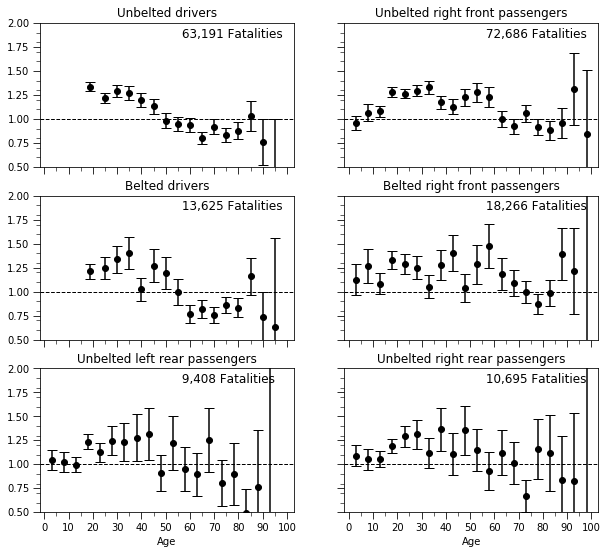

In [35]:
fig = plot_doublepair(vehicle_results['PASSENGER_CAR'])
fig.savefig(fig_out / "passenger_car_subsets.png", dpi=360)

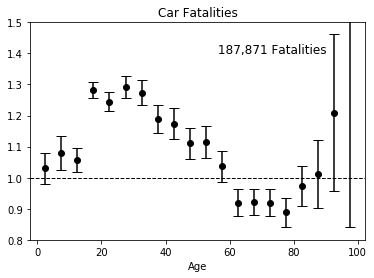

In [47]:
car_result = combine_results(vehicle_results['PASSENGER_CAR']['results'])
car_counts = vehicle_results['PASSENGER_CAR']['counts']
fig = plot_single(car_result, car_counts, "Car Fatalities")
fig.savefig(fig_out / "passenger_cars.png", dpi=360)

## Results: Light Truck

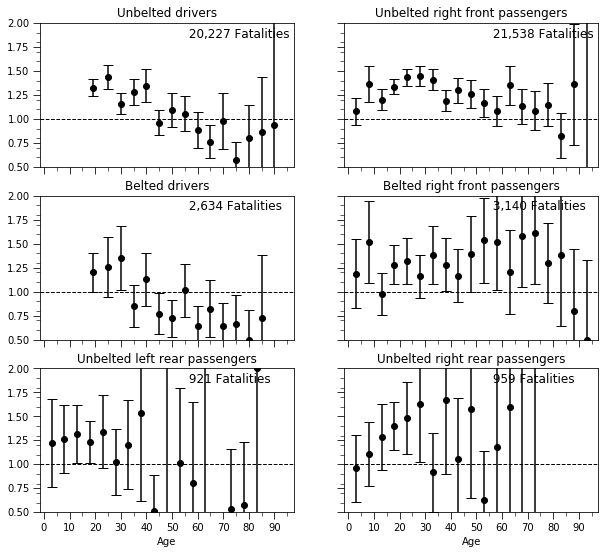

In [49]:
fig = plot_doublepair(vehicle_results['LIGHT_TRUCK_OR_VAN'])
fig.savefig(fig_out / "truck_subsets.png", dpi=360)

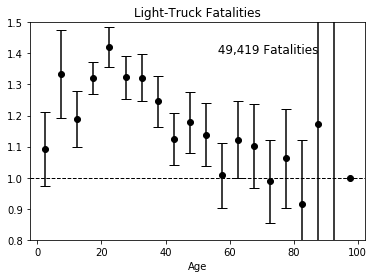

In [50]:
truck_result = combine_results(vehicle_results['LIGHT_TRUCK_OR_VAN']['results'])
truck_counts = vehicle_results['LIGHT_TRUCK_OR_VAN']['counts']
fig = plot_single(truck_result, truck_counts, "Light-Truck Fatalities")
fig.savefig(fig_out / "light_trucks.png", dpi=360)

## Results: Motorcycles

In [ ]:
fig, axes = plt.subplots(1,2, figsize=(10,3), sharex=True, sharey=True)
results = vehicle_results['MOTORCYCLE']['results']
titles = vehicle_results['MOTORCYCLE']['titles']
counts = vehicle_results['MOTORCYCLE']['counts']
a=[]
for i, ax in enumerate(axes):
    a.append(ax)

for i, ax in enumerate(a):
    ax.axhline(1, color='black', lw=1, ls='--')
    results[i].plot(x='Age', y='R', yerr='DeltaR', capsize=5, fmt='ko',
                  ylim = (.5, 2), title=titles[i],
                   ax = ax, legend=False)
    ax.text(55, 1.85, f"{counts[i]: ,} Fatalities", fontsize=12)

    ax.xaxis.set_major_locator(MultipleLocator(10))
    ax.xaxis.set_minor_locator(MultipleLocator(5))
    ax.tick_params(which='major', length=7)
    ax.tick_params(which='minor', length=4)
    #axis.yaxis.set_major_locator(MultipleLocator(10))
    ax.yaxis.set_minor_locator(MultipleLocator(.1))

plt.show()
fig.savefig(fig_out / "motorcycle_subsets.png", dpi=360)

In [ ]:
mcycl_result = combine_results(vehicle_results['MOTORCYCLE']['results'])
mcycl_counts = vehicle_results['MOTORCYCLE']['counts']
fig = plot_single(mcycl_result, mcycl_counts, "Motorcycle Fatalities")
fig.savefig(fig_out / "motorcycles.png", dpi=360)

## All Occupants

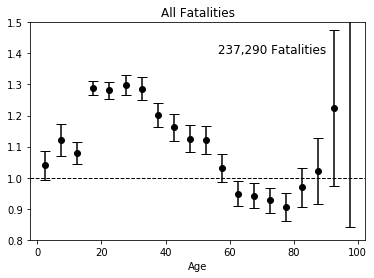

In [56]:
all_results = [car_result, truck_result, mcycl_result]
final_result = combine_results(all_results)
fig = plot_single(final_result, [sum(truck_counts), sum(car_counts), sum(mcycl_counts)], "All Fatalities")
fig.savefig(fig_out / "all_fatalities.png", dpi=360)

## Tables
Tables produced for review, also output as .xlsx and .csv files for easy transfer to papers.

In [ ]:
csv_out = Path(module_path) / "reports" / "tables" / image_outputs / "csv"
xlsx_out = Path(module_path) / "reports" / "tables" / image_outputs / "xlsx"
csv_out.mkdir(parents=True, exist_ok=True)
xlsx_out.mkdir(parents=True, exist_ok=True)

In [ ]:
for veh_type, cur_veh in vehicle_results.items():
    veh_csv = csv_out / veh_type
    veh_xlsx = xlsx_out / veh_type
       
    for title, res, all_res in zip(cur_veh['titles'], 
                                   cur_veh['results'], 
                                   cur_veh['all_res']):
        cur_csv = veh_csv / title
        cur_xlsx = veh_xlsx / title
        cur_csv.mkdir(parents=True, exist_ok=True)
        cur_xlsx.mkdir(parents=True, exist_ok=True)
    
        #Write out table of weighted results
        res.to_csv(cur_csv / 'weighted_results.csv', float_format='%.3f')
        #res.to_excel(cur_xlsx / 'weighted_results.csv')
        
        #Write out table of all results
        all_res.to_csv(cur_csv / 'full_results.csv', float_format='%.3f')
        
        #Loop through each subject interval in all_res, write out this table
        for subj_age in all_res['Subject Age'].unique():
            cur_chunk = all_res.loc[all_res['Subject Age'] == 
                                    subj_age].sort_values('Control Sex', ascending=False)
            cur_chunk.to_csv(cur_csv / f"subjects_{subj_age}.csv", float_format='%.3f')
car_result.to_csv(csv_out / "full_car_weighted.csv")
truck_result.to_csv(csv_out / "full_truck_weighted.csv")
mcycl_result.to_csv(csv_out / "full_motorcycle_weighted.csv")
final_result.to_csv(csv_out / "full_weighted_result.csv")

In [ ]:
%reset -f